# Introduction to Convolutional Neural Networks

Convolutional Neural Networks (CNN) are one of the key components in the success of Deep Learning and the new Artificial Intelligence revolution. They are specially advantageous in tasks such as object detection, scene understanding and, recently, natural language processing. In this jupyter notebook I will explain what is a convolution and how to train a CNN with the character recognition dataset MNIST.

*NOTE: Make sure your PyTorch version is compatible with your CUDA drivers. In my case, I installed `pip install torch torchvision --index-url https://download.pytorch.org/whl/cu116`*


In [1]:
# Load all needed libraries
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
import cv2
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

print("OS:", sys.platform)
print("Python:", sys.version)
print("Numpy:", np.__version__)
print("PyTorch:", torch.__version__)
print("CUDA:", torch.cuda.is_available())

%matplotlib inline


OS: linux
Python: 3.12.11 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:09:17) [GCC 11.2.0]
Numpy: 2.2.6
PyTorch: 2.8.0+cu128
CUDA: True


## Convolution

CNN are the key resource in deep learning. They are based on a mathematical operation called convolution. A convolution is just a multiplication of an input image (which is a matrix) times a kernel (which is another matrix).

In opencv there is a function called filter2D that allows to generate convolutions. 

In [2]:
def plot_image(image, image2=None):
    # Show one image
    plt.subplot(121)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.axis("off")
    plt.xticks([]), plt.yticks([])
    if image2 is not None:
        # Show two images
        plt.subplot(122)
        if len(image2.shape) == 3:
            image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            plt.imshow(image2)
        else:
            plt.imshow(image2, cmap=plt.get_cmap("gray"))
        plt.axis("off")
        plt.xticks([]), plt.yticks([])
    plt.show()

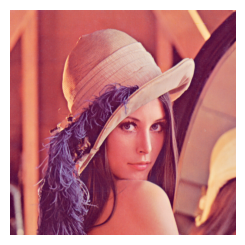

In [3]:
im = cv2.imread("Lenna.png")
plot_image(im)

In [4]:
## Sharpening filter
sharpen = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]), dtype="int")
# Laplacian kernel used to detect edges
laplacian = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]), dtype="int")
# Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype="int")
# Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype="int")

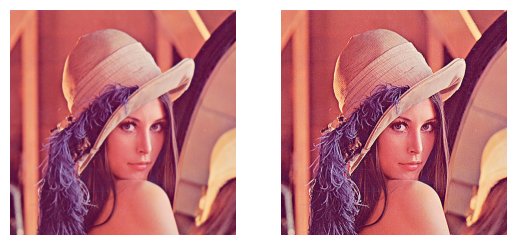

In [5]:
dst = cv2.filter2D(im, -1, sharpen)
plot_image(im, dst)

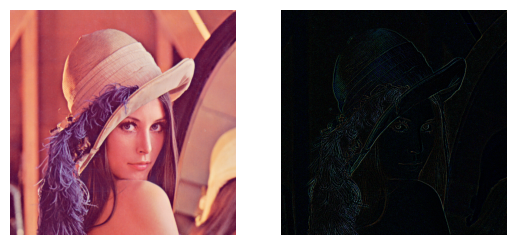

In [6]:
dst = cv2.filter2D(im, -1, laplacian)
plot_image(im, dst)

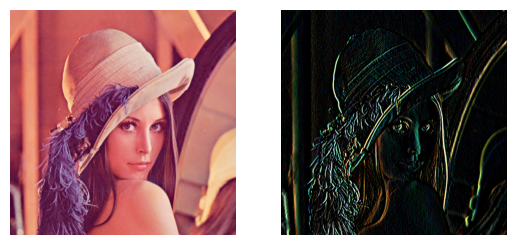

In [7]:
dst = cv2.filter2D(im, -1, sobelX)
plot_image(im, dst)

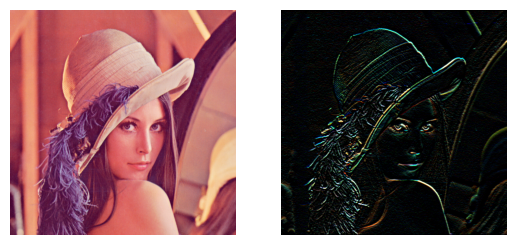

In [8]:
dst = cv2.filter2D(im, -1, sobelY)
plot_image(im, dst)

## Character recognition with MNIST dataset

We are going to use MNIST dataset and Lenet CNN architecture to showcase a deep learning task consisting in recognizing handwritting characters. 

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains a training set of 60,000 examples, and a test set of 10,000 examples of hand writting characters.

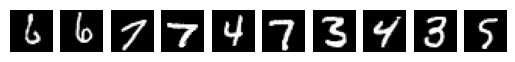

In [9]:
# Load MNIST data
mnist = fetch_openml("mnist_784", version=1)

# Convert the data and target to NumPy arrays
X = mnist.data.to_numpy()
Y = mnist.target.to_numpy()

# Shuffle the data
np.random.seed(1234)
p = np.random.permutation(X.shape[0])  # Get permutation of indices
X = X[p].astype(np.float32) / 255  # Normalize the data
Y = Y[p].astype(int)

# Visualize the first 10 images
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i].reshape((28, 28)), cmap="Greys_r")
    plt.axis("off")
plt.show()

# Train/test split and reshape to PyTorch format (batch_size, channels, height, width)
X_train = X[:60000].reshape((-1, 1, 28, 28))
X_test = X[60000:].reshape((-1, 1, 28, 28))
Y_train = Y[:60000]
Y_test = Y[60000:]

# Create PyTorch datasets and loaders
batch_size = 100
train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
test_dataset = TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## CNN model: Lenet

Lenet architecture was published by [Yann LeCun et al.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) in 1998. The LeNet architecture uses convolutions and pooling to increase the performance. For many years, LeNet was the most accurate algorithm for character recognition and supposed a great advance in deep neural networks, long before the appearance of GPUs and CUDA.

As it can be seen in the following code Lenet has 4 groups of hidden layers, two convolutions and two fully connected layers. Each convolution is followed by an activation and a pooling. 

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # Conv1: 1 input channel (grayscale), 20 output feature maps, 5x5 kernel
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5)
        # Conv2: 20 input feature maps, 50 output feature maps, 5x5 kernel
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5)
        # FC1: 50 filters with 4x4 feature map after pooling
        self.fc1 = nn.Linear(50 * 4 * 4, 500)
        # FC2: 500 input features, 10 output features (for 10 classes)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = torch.tanh(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = torch.tanh(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 50 * 4 * 4)  # Flatten the tensor
        x = torch.tanh(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)  # Softmax for output layer


# Instantiate the model
model = LeNet()

## Training
Once we have the model and the data, let's put it together and train the CNN.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()


# Training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} "
                f"({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}"
            )


# Testing loop
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # Sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print(
        f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} "
        f"({100. * correct / len(test_loader.dataset):.0f}%)\n"
    )


# Train for 10 epochs
for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

cuda
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309674
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.178309
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.027308

Test set: Average loss: 0.0007, Accuracy: 9789/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.003355
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.024490
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.020269

Test set: Average loss: 0.0006, Accuracy: 9844/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.005393
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.022597
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.024251

Test set: Average loss: 0.0006, Accuracy: 9837/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.023253
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.000419
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.003883

Test set: Average loss: 0.0005, Accuracy: 9893/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.000909
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.000420
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.003119

Test set: Average loss: 0